# COVID-19 predictions

Pablo Carbonell, pablocarb@gmail.com

Thanks https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html for coding templates!

The dynamics of the COVID-19 will be modelled using the SIR model:

$\begin{eqnarray}
\frac{dS}{dt} & = &  - \beta \frac{I S}{N} \\
\frac{dI}{dt} & = & \beta I_t \frac{I S}{N} - \gamma I \\
\frac{dR}{dt}  & = & \gamma I
\end{eqnarray}$

where $S$ is the stock of susceptible population, $I$ is the stock of infected, $R$ is the stock of recovered population, and $N$ is the sum of these three.

 - $\beta$ is the average number of contacts per person per time;
 - $\gamma$ is the rate of recovered
 - $R_0 = \frac{\beta}{\gamma}$ is the basic reproduction number.

As in https://covid19.webs.upv.es/, the previous equations for the SIR model can be approximated using the following difference equation:

$\begin{eqnarray}
S_{t+1} & = & S_t - \beta S_t \frac{I_t}{n_T} \\
I_{t+1} & = & I_t + \beta S_t \frac{I_t}{n_T} - \gamma I_t \\
R_{t+1} & = & R_t + \gamma I_t
\end{eqnarray}$

where $S$ are the susceptible population, $I$ is the infected and $R$ the recovered. 

In order to estimate the parameters of the model $(\hat \beta, \hat \gamma)$, we will use an optimizer that will minimize the root mean square difference between the predicted infected population $I$ and the actual infected retrieved from official data.

Rather than fitting a static model, our goal is to estimate $(\hat \beta_k, \hat \gamma_k)$ over time, i.e., to see how the model readjusts itself in function of external factors. Such external factors are for instance confinement measures limiting population contact.

In [2]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import math
import time
from datetime import timedelta, datetime
plt.style.use('seaborn-darkgrid')


In [3]:
#%%
# Retrieve world-wide data
reload = True
if 'reload' not in locals() or reload:
    confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
    deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
    recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
    reload = False
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [4]:
# Adapted from https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html

START_DATE = {
  'Japan': '1/22/20',
  'Italy': '2/15/20',
  'Republic of Korea': '1/22/20',
  'Iran (Islamic Republic of)': '2/19/20',
  'Spain': '3/1/20',
  'France':'3/15/20'
}

# Total population, N.
country = 'Spain'
ix = confirmed_df['Country/Region'] == country

POPULATION = {
        'Italy' : 60*1000000.0,
        'Spain' : 45*1000000.0,
        'France': 67*1e6
        }
N = POPULATION[country]
# Initial number of infected and recovered individuals, I0 and R0.

incubation_days = 30
incub = int( np.argwhere( confirmed_df.keys() == START_DATE[country] ) ) - incubation_days
I_0 = confirmed_df[ix].iloc[0].loc[START_DATE[country]]
R_0 = recoveries_df[ix].iloc[0].loc[START_DATE[country]]
R_0 = I_0-deaths_df[ix].iloc[0].loc[START_DATE[country]]

I_0 = confirmed_df[ix].iloc[0].loc[START_DATE[country]] - confirmed_df[ix].iloc[0].iloc[incub]
R_0 = I_0-deaths_df[ix].iloc[0].loc[START_DATE[country]] + deaths_df[ix].iloc[0].iloc[incub]

# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0
#S_0 = S_0/N
#I_0 = I_0/N
#R_0 = R_0/N
class Learner(object):
    def __init__(self, country, loss, confirmed=None, plot= False, verbose=False ):
        self.country = country
        self.loss = loss
        self.confirmed = confirmed
        self.plot = plot
        self.verbose = verbose

    def load_confirmed(self, country, confirmed_df, incubation=True):
        ix = confirmed_df['Country/Region'] == country
        conf = confirmed_df[ix].iloc[0].loc[START_DATE[country]:]
        if incubation:
            incub = int( np.argwhere( confirmed_df.keys() == START_DATE[country] ) ) - incubation_days
            conf1 = conf.copy()
            for i in np.arange(len(conf)):
                conf1.iloc[i] = conf.iloc[i] - confirmed_df[ix].iloc[0].iloc[incub+i] 
            conf = conf1
        return conf

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values


    def predict(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 60
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def dSIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [S-beta*S*I/N, I+beta*S*I/N - gamma*I, R+gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, dsolve_ivp(dSIR, t_eval=[0, size], y0=[S_0,I_0,R_0])



    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        data = self.load_confirmed(self.country, self.confirmed)
        self.data = data
        optimal = minimize(
            self.loss,
#            [0.001, 0.001],
            [1/S_0, R_0/I_0],
            args=(data),
            method='Powell',
#            method='L-BFGS-B',
 #           bounds=[(0.00000001, 0.4), (0.00000001, 0.4)],
            bounds=[(1e-3, 10), (0.1, 10)],
            options={'maxiter':1000000,'disp':True,'ftol':1e-6}
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction[:,0],
            'I': prediction[:,1],
            'R': prediction[:,2]
        }, index=new_index)
#        df = df*N
#        df[['I','Actual']].plot(ax=ax)
        if self.plot:
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.set_title(self.country)
            plt.plot(df[['I','Actual']])
            plt.xticks(rotation=90)
            plt.legend(['Infected (predicted)','Infected (actual)'])
#        plt.grid()
        self.df = df
        self.beta = beta
        self.gamma = gamma


def dsolve_ivp(fun, t_eval, y0):
        y = y0
        sol = []
        for t in np.arange(t_eval[0], t_eval[1]):
            y = fun(t,y)
            sol.append(y)
        sol = np.array(sol)
        return sol



def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    Using a discrete model
    """
    size = len(data)
    beta, gamma = point
    def dSIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [S-beta*S*I/N, I+beta*S*I/N - gamma*I, R+gamma*I]
    sol = dsolve_ivp(dSIR, t_eval=[0, size], y0=[S_0,I_0,R_0])
    rmsd = np.sqrt(np.mean((sol[:,1] - data)**2))
    return rmsd


/Users/mibsspc2/anaconda/envs/pathdes/lib/python3.5/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: 1913.221011
         Iterations: 2
         Function evaluations: 72


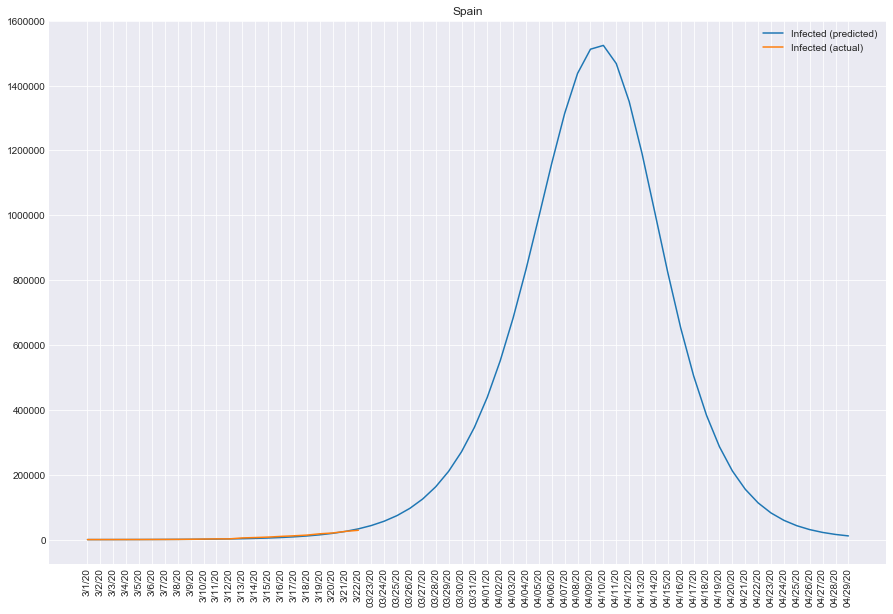

In [6]:
learn = Learner(country, loss, confirmed_df, plot=True)
learn.train()
